# Node embedding by DeepWalk

In [52]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#%matplotlib inline


In [53]:
operation = pd.read_csv('./df_pipe.csv', header=0, index_col=0, sep=';').dropna().reset_index(drop=True)
operation

,Source,Target
0,switch_greeting,switch_pa
1,switch_greeting,switch_step_count
2,switch_greeting,switch_inconvenient
3,switch_greeting,switch_memory_recall
4,switch_greeting,switch_goal_setting
5,switch_greeting,switch_rating_importance
6,switch_greeting,switch_rating_confidence
7,switch_greeting,switch_self_efficacy
8,switch_pa,switch_inconvenient
9,switch_pa,switch_goal_setting


In [54]:
# data_operations = {'initial': ['import_packages', 'load_data', 'save_data', 'create_dataframe', 'index_info', 'column_name_all', 'dataset_length', 'dataset_shape', 'dataset_dtype', 'dataset_describe', 'extract_specific_column_by_name', 'extract_specific_row_by_index', 'head_overview', 'tail_overview', 'nan_matrix', 'where_nan', 'where_specified_element', 'unique_value_in_specific_column'],

# 'pre-processing': ['find_missing_date', 'change_to_datetime', 'sort_index', 'reset_index', 'sort_value_by_column', 'set_index_by_specified_column', 'group_by_column', 'delete_by_column_row', 'drop_na', 'fill_na', 'drop_duplicates', 'extract_duplicates', 'rename_column', 'add_new_row', 'merge_dataframe', 'concat_dataframe', 'filter_by_conditions', 'sampling', 'train_test_split', 'scaler', 'insert_new_column', 'change_specified_column_type', 'one_hot_encoding'],

# 'feature engineering': ['correlation_matrix', 'feature_selection'],                         
            
# 'visualization': ['distribution', 'heatmap', 'plot'],
                
# 'model construction': ['regression_model', 'classification_model', 'clustering_model'],

# 'module workflow': ['initial_pipeline', 'preprocessing_pipeline', 'feature_engineering_pipeline', 'regression_model_pipeline', 'classification_model_pipeline', 'outlier']}

In [55]:
G = nx.from_pandas_edgelist(operation, "Source", "Target", create_using=nx.DiGraph())

print(nx.is_directed(G))
len(G)

True


10

In [56]:
all_nodes = list(G.nodes())
all_nodes

['switch_greeting',
 'switch_pa',
 'switch_step_count',
 'switch_inconvenient',
 'switch_memory_recall',
 'switch_goal_setting',
 'switch_rating_importance',
 'switch_rating_confidence',
 'switch_self_efficacy',
 'switch_motivator']

In [57]:
# function to generate random walk sequences of nodes
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk


random_walk = get_randomwalk('switch_greeting', 10)
random_walk

['switch_greeting', 'switch_goal_setting']

In [58]:
all_nodes = list(G.nodes())

random_walks = []

for n in tqdm(all_nodes):
    for i in range(10): # number of sentence start from n
        random_walks.append(get_randomwalk(n,10)) # length of sentence

100%|██████████| 10/10 [00:00<00:00, 15363.75it/s]


In [59]:
# count of sequences
len(random_walks)

100

In [96]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

# train word2vec model
model = Word2Vec(window=3, sg=1, hs=0,
                 negative=10, # for negative sampling
                 alpha=0.05, min_alpha=0.0007,
                 seed=14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

print(model)

Word2Vec(vocab=10, vector_size=100, alpha=0.05)


In [97]:
# find top n similar nodes 
model.wv.most_similar('switch_greeting')

[('switch_step_count', 0.23566599190235138),
 ('switch_inconvenient', 0.1881372332572937),
 ('switch_motivator', 0.10166289657354355),
 ('switch_pa', 0.050793059170246124),
 ('switch_memory_recall', 0.012891405262053013),
 ('switch_goal_setting', -0.01794905588030815),
 ('switch_rating_confidence', -0.05038347840309143),
 ('switch_self_efficacy', -0.05711626634001732),
 ('switch_rating_importance', -0.08758489042520523)]

In [98]:
a = model.wv["switch_rating_importance", "switch_inconvenient"]
print(np.shape(a))
a


(2, 100)


array([[-1.0668184e-03, -8.1549957e-03, -7.8768720e-04, -7.2308788e-03,
         7.1806349e-03, -4.7860229e-03, -1.5717576e-03, -9.0696551e-03,
        -2.9832656e-03,  9.9576041e-03, -5.3263362e-03,  3.3114450e-03,
        -1.0094223e-02, -7.4415449e-03, -4.7951192e-03,  8.0735178e-04,
        -3.5169609e-03, -2.1470017e-03,  3.7402725e-03, -6.0714479e-03,
         6.9115469e-03, -2.0648590e-03, -1.7851620e-03,  6.1212742e-04,
        -9.1829496e-03, -7.4128294e-03,  9.1881910e-03,  9.8615792e-03,
        -9.5951846e-03, -7.3611201e-04,  5.1433262e-03, -8.8508064e-03,
         2.3407595e-04,  3.4299137e-03, -1.5223698e-03,  9.5677441e-03,
         2.3581816e-03, -9.9531645e-03, -6.5153087e-03,  3.1477748e-03,
        -5.2355989e-03,  6.8422649e-03, -2.6659507e-04, -7.5496756e-04,
         2.5371038e-03, -9.3239844e-03, -8.9929998e-03,  4.9237222e-03,
         2.5785472e-03, -2.9127914e-03, -1.3932439e-03, -4.6091750e-03,
        -2.0905607e-03,  5.3529763e-03,  1.0505603e-02, -9.78496

In [99]:
def plot_nodes(word_list, save_name):
    X = model.wv[word_list]

    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(10,6))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.savefig(save_name)
    plt.show()

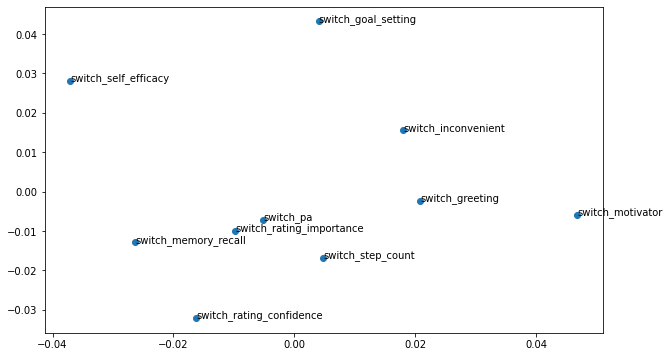

In [100]:
plot_nodes(all_nodes, 'all_nodes.jpg')

In [103]:
from sklearn.preprocessing import StandardScaler

emb_node = model.wv[all_nodes]

scaler = StandardScaler()
scaler.fit(emb_node)
emb_node_scale = scaler.transform(emb_node)


(10, 10)


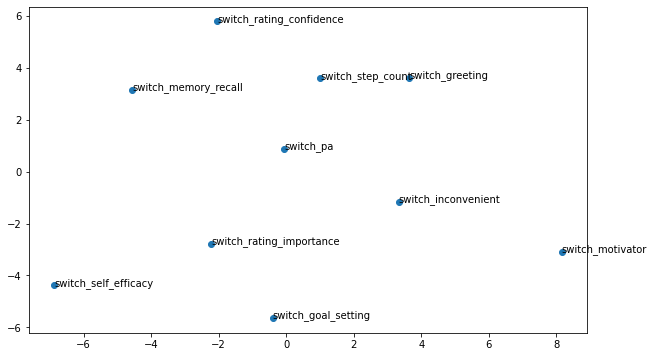

In [110]:
def plot_emb_sim(X, word_list, save_name):
    #X = model[word_list]
    # reduce dimensions to 2
    pca = PCA(n_components=10)
    result = pca.fit_transform(X)
    print(np.shape(result))
    
    plt.figure(figsize=(10,6))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])

    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.savefig(save_name)
    plt.show()


plot_emb_sim(emb_node_scale, all_nodes, 'emb_node_scale.png')

# BERT embedding

In [11]:
import pandas as pd
import numpy as np
import pickle
from bert_embedding import BertEmbedding

In [12]:
oper2ind = dict()
for i, item in enumerate(all_nodes):
    oper2ind[item] = i

ind2oper = dict()
for i, item in enumerate(oper2ind):
    ind2oper[i] = item

In [13]:
#np.save('./Embeddings/oper2ind.npy', oper2ind) 
#np.save('./Embeddings/ind2oper.npy', ind2oper) 

In [18]:
def oper_dict_bert_emb(oper2ind, save_path, load):
    if load == False:
        bert_embedding = BertEmbedding()
        emb_bert = bert_embedding(list(oper2ind.keys()))
        oper_bert_emb = dict()
        opers = list(oper2ind.keys())
        for i, oper in enumerate(opers):
            oper_bert_emb[oper] = np.array(emb_bert[i][1]).sum(axis=0).transpose()
        np.save(save_path, oper_bert_emb) 
    else: 
        return np.load(save_path, allow_pickle=True).item()

In [21]:
#oper_dict_bert_emb(oper2ind, './dict_bert_emb.npy', False)

dict_bert_emb = oper_dict_bert_emb(oper2ind, './Embeddings/dict_bert_emb.npy', True)

In [22]:
len(dict_bert_emb)

55

In [23]:
a = dict_bert_emb['classification_model_pipeline']
b = dict_bert_emb['preprocessing_pipeline']

res = np.vstack((a, b))
np.shape(res)

(2, 768)

In [24]:
def bert_emb(dict_bert_emb, word_lists):

    stack = []
    for i, item in enumerate(all_nodes):
        tem = np.array(dict_bert_emb[item])
        '''
        a = np.array(result[0][1]).sum(axis=0).transpose()
        b = np.array(result[1][1]).sum(axis=0).transpose()
        c = np.array(result[2][1]).sum(axis=0).transpose()
        d = np.array(result[3][1]).sum(axis=0).transpose()
        '''
        stack.append(tem)
    emb = np.vstack(stack)
    return emb
    
'''
def plot_emb_sim(X, word_list):
    #X = model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print(np.shape(result))
    
    plt.figure(figsize=(15,10))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])

    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.show()
'''

&#39;\ndef plot_emb_sim(X, word_list):\n    #X = model[word_list]\n    \n    # reduce dimensions to 2\n    pca = PCA(n_components=2)\n    result = pca.fit_transform(X)\n    print(np.shape(result))\n    \n    plt.figure(figsize=(15,10))\n    # create a scatter plot of the projection\n    plt.scatter(result[:, 0], result[:, 1])\n\n    for i, word in enumerate(word_list):\n        plt.annotate(word, xy=(result[i, 0], result[i, 1]))\n\n    plt.show()\n&#39;

(55, 10)


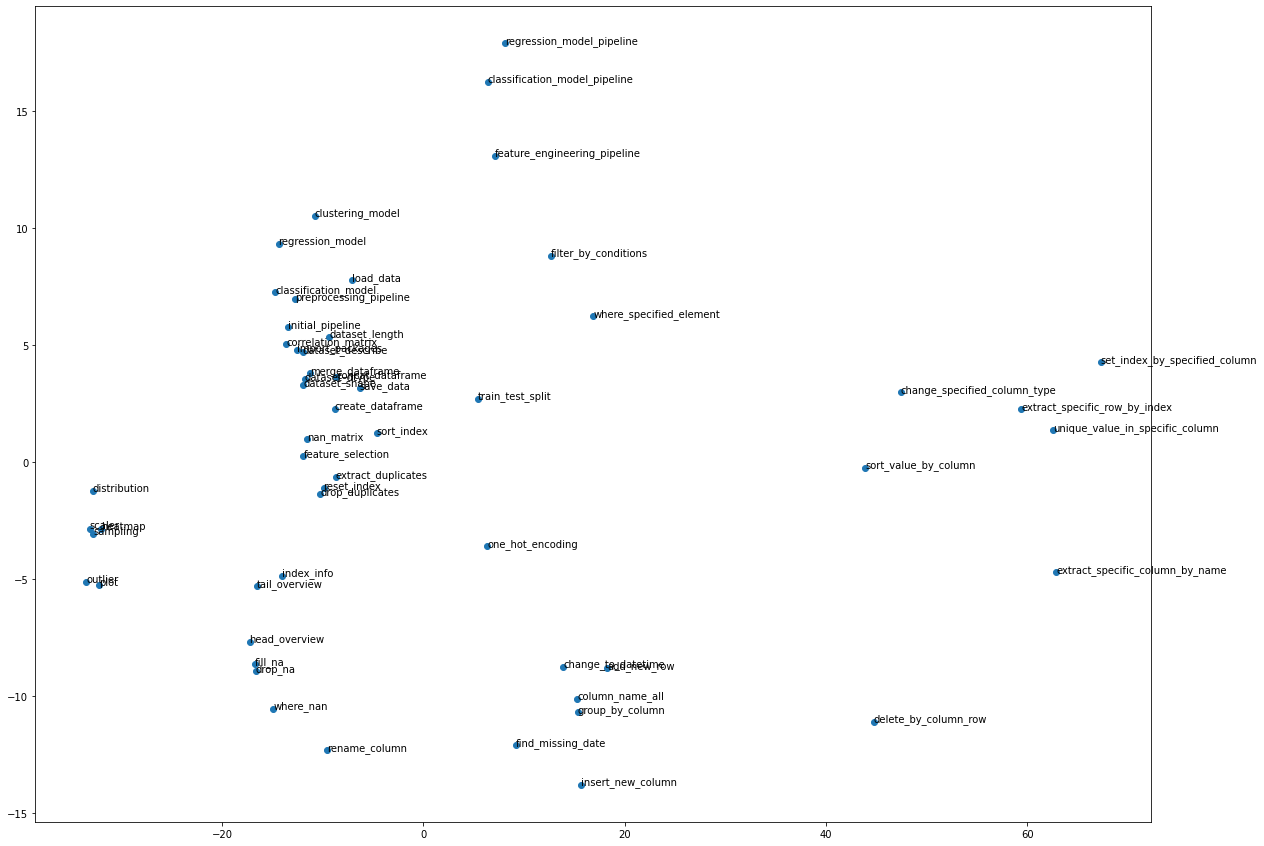

In [25]:
emb_bert = bert_emb(dict_bert_emb, all_nodes)

plot_emb_sim(emb_bert, all_nodes, 'emb_bert.jpg')

In [26]:
np.save('./emb_bert.npy', emb_bert)

np.save('./emb_node.npy', emb_node) 

# Combined BERT and Node embedding

In [41]:
np.shape(emb_bert)
np.shape(emb_node)

(55, 100)

In [68]:
emb_node = np.load('./emb_node.npy', allow_pickle=True)
emb_bert = np.load('./emb_bert.npy', allow_pickle=True)

In [27]:
print(np.shape(emb_node))
print(np.shape(emb_bert))

(55, 100)
(55, 768)


In [28]:
def pca(X, n):
    pca = PCA(n_components=n, svd_solver='auto')
    result = pca.fit_transform(X)
    return result

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(emb_node)
emb_node_scale = scaler.transform(emb_node)

scaler = StandardScaler()
scaler.fit(emb_bert)
emb_bert_scale = scaler.transform(emb_bert)

emb_final = np.concatenate((pca(emb_node_scale,50), pca(emb_bert_scale, 50)), axis=1)
print(np.shape(emb_final))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(emb_final)

emb_final_scale = scaler.transform(emb_final)

(55, 100)


(55, 10)


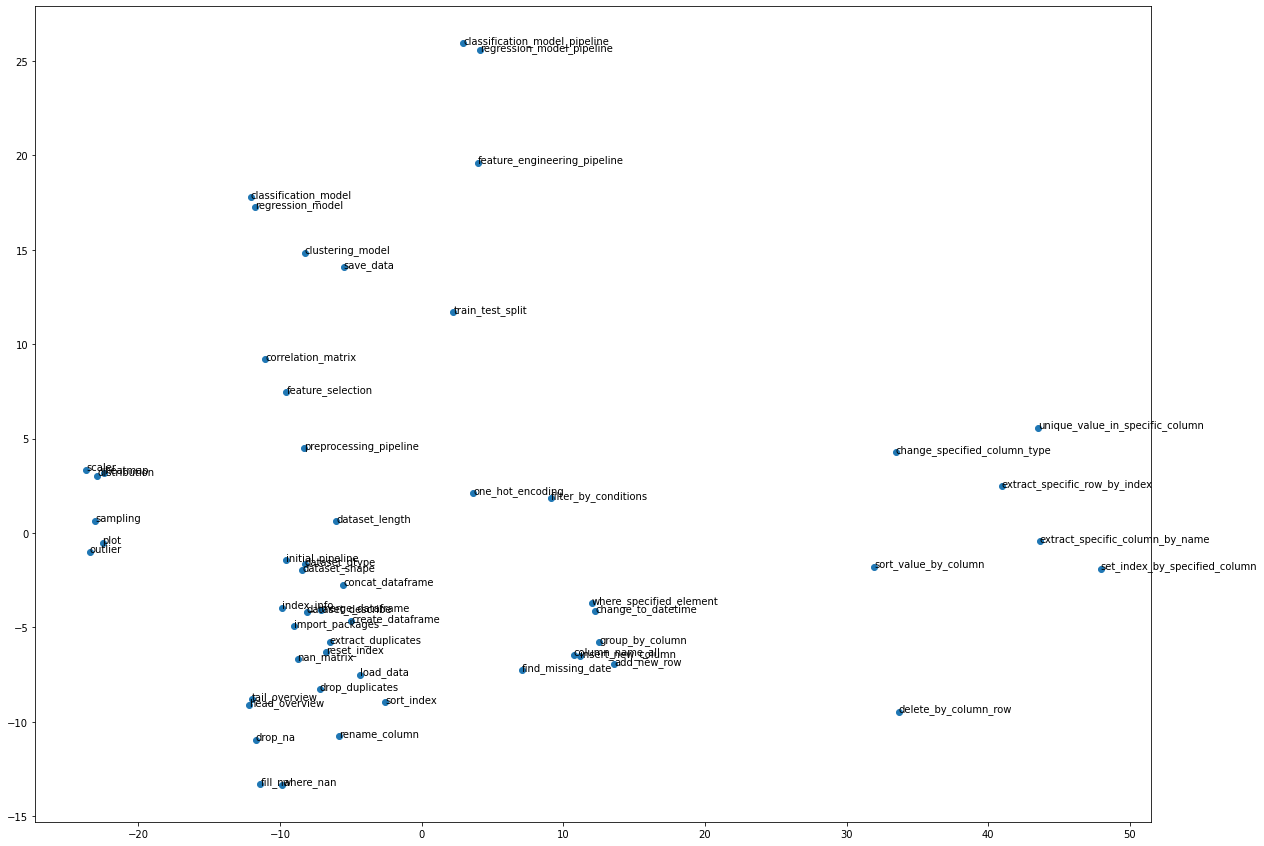

In [30]:
plot_emb_sim(emb_final, all_nodes, 'emb_final.jpg')

(55, 10)


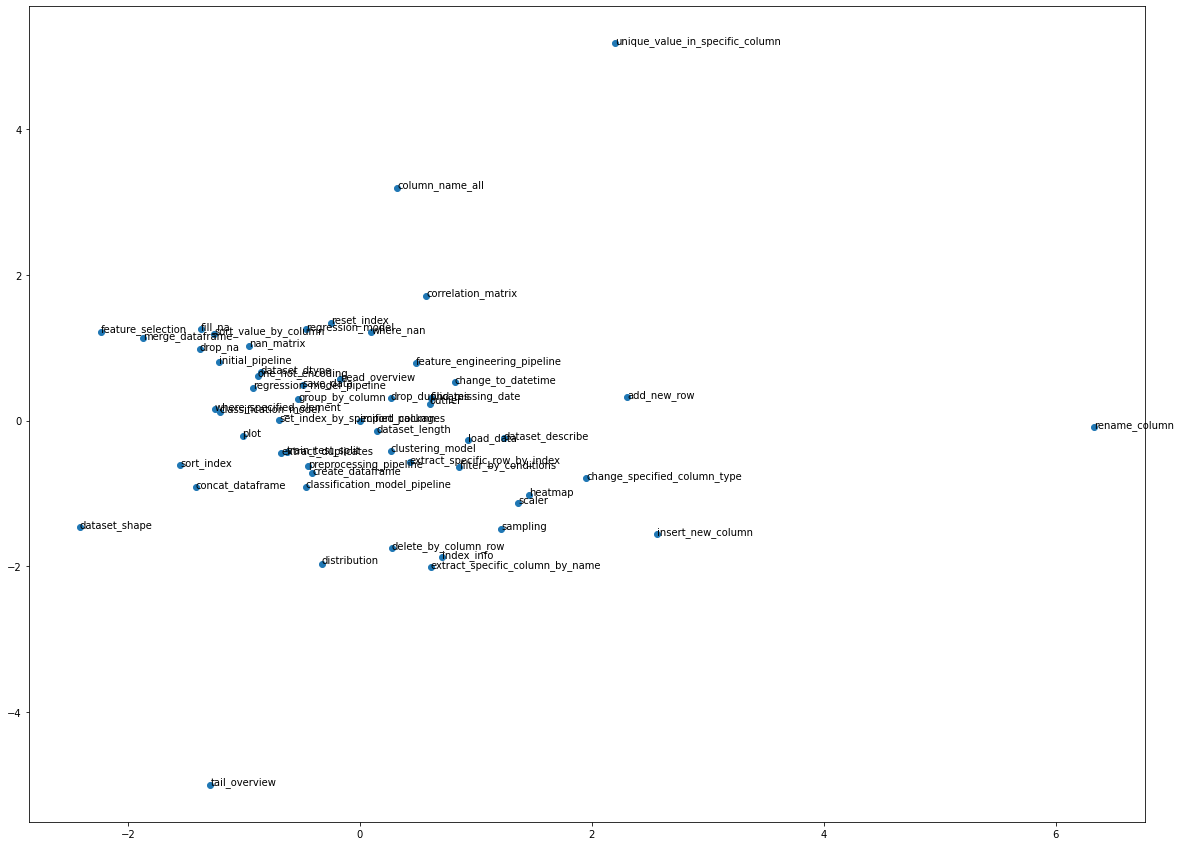

In [31]:
plot_emb_sim(emb_final_scale, all_nodes, 'emb_final_scale')

(55, 10)


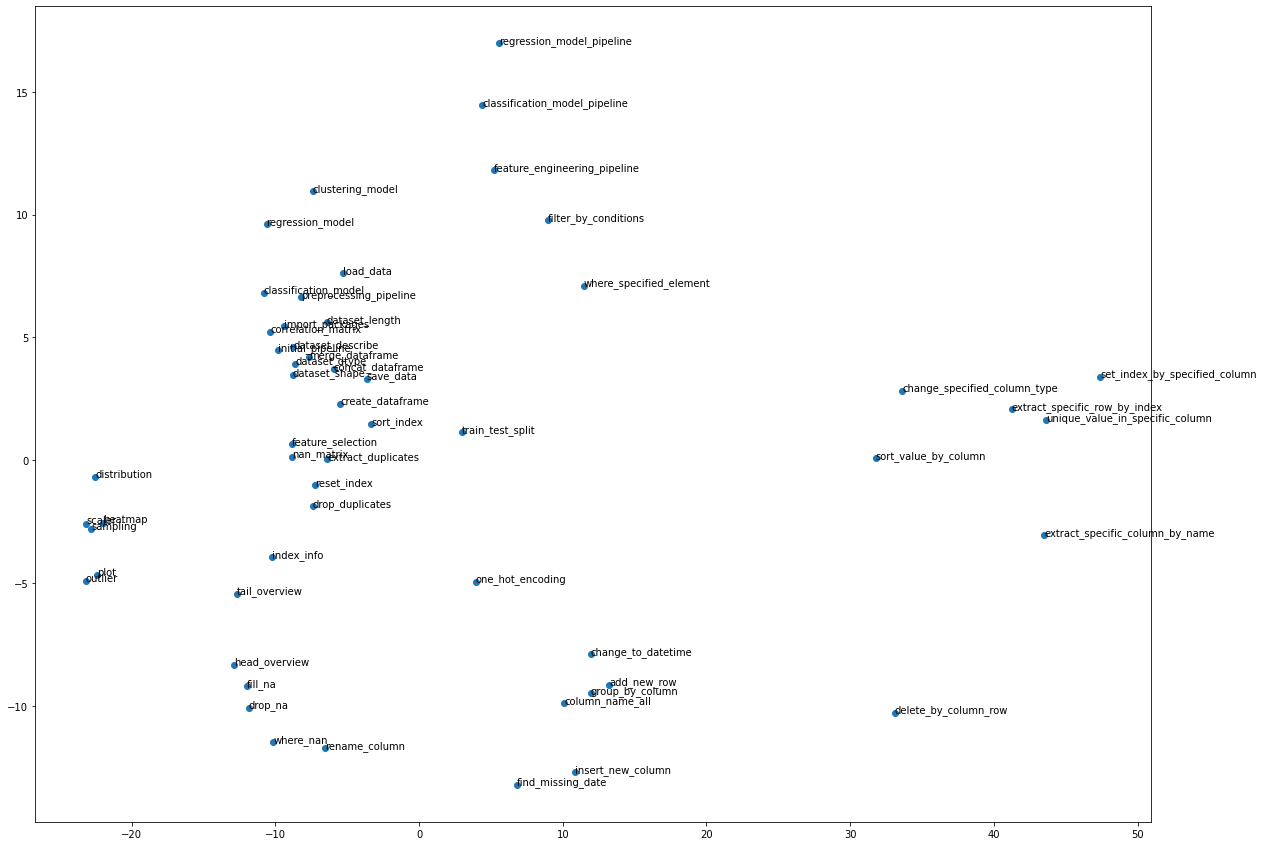

In [32]:
plot_emb_sim(pca(emb_bert_scale, 10), all_nodes, 'test')


(53, 2)


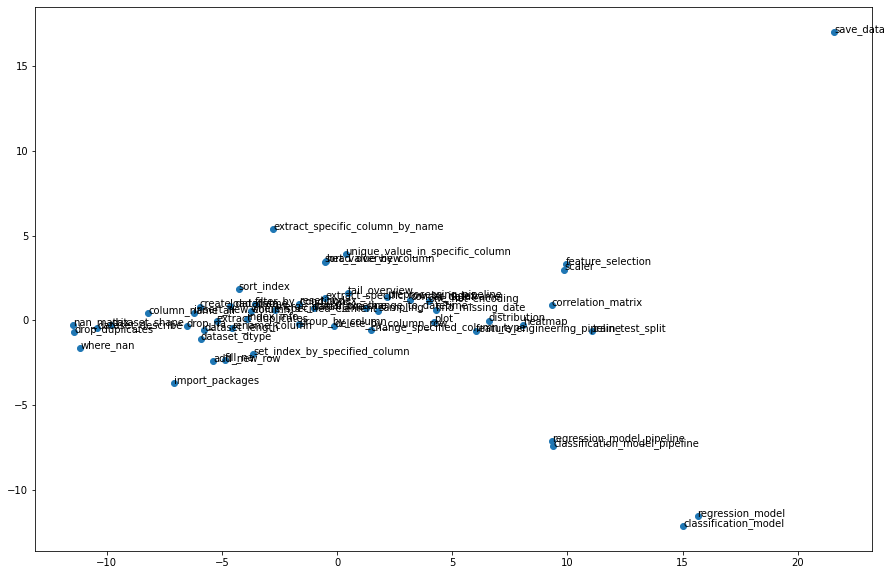

In [59]:
plot_emb_sim(emb_node_scale, all_nodes)


In [33]:
np.save('./emb_final.npy', emb_final) 

# save embedding dict

In [34]:
emb_node = model[all_nodes]
dict_node_emb = dict()
for i, item in enumerate(all_nodes):
    dict_node_emb[item] = emb_node[i]


dict_final_emb = dict()
for i, item in enumerate(all_nodes):
    dict_final_emb[item] = emb_final[i]

In [35]:
np.save('./dict_node_emb.npy', dict_node_emb) 

np.save('./dict_final_emb.npy', dict_final_emb) 

# Construct dataset for training and testing

In [111]:
G = nx.from_pandas_edgelist(operation, "Source", "Target", create_using=nx.DiGraph())

print(nx.is_directed(G))
len(G)

True


10

In [112]:
# function to generate random walk sequences of nodes
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [114]:
all_nodes = list(G.nodes())

all_nodes

['switch_greeting',
 'switch_pa',
 'switch_step_count',
 'switch_inconvenient',
 'switch_memory_recall',
 'switch_goal_setting',
 'switch_rating_importance',
 'switch_rating_confidence',
 'switch_self_efficacy',
 'switch_motivator']

In [115]:
random_walks = []
sentence_length = [3, 5, 7, 10]

for lens in sentence_length:
    for n in tqdm(all_nodes):  
        for i in range(10):
            random_walks.append(get_randomwalk(n, lens))

100%|██████████| 10/10 [00:00<00:00, 23858.38it/s]


In [116]:
len(random_walks)

400

In [120]:
print(np.shape(random_walks))
random_walks

(400,)


[['switch_greeting', 'switch_goal_setting'],
 ['switch_greeting', 'switch_rating_importance', 'switch_self_efficacy'],
 ['switch_greeting', 'switch_memory_recall'],
 ['switch_greeting', 'switch_pa', 'switch_self_efficacy'],
 ['switch_greeting', 'switch_pa', 'switch_inconvenient'],
 ['switch_greeting', 'switch_inconvenient'],
 ['switch_greeting', 'switch_rating_importance', 'switch_motivator'],
 ['switch_greeting', 'switch_self_efficacy', 'switch_motivator'],
 ['switch_greeting', 'switch_rating_importance', 'switch_self_efficacy'],
 ['switch_greeting', 'switch_self_efficacy', 'switch_motivator'],
 ['switch_pa', 'switch_motivator'],
 ['switch_pa', 'switch_self_efficacy', 'switch_motivator'],
 ['switch_pa', 'switch_rating_importance', 'switch_self_efficacy'],
 ['switch_pa', 'switch_motivator'],
 ['switch_pa', 'switch_goal_setting'],
 ['switch_pa', 'switch_goal_setting'],
 ['switch_pa', 'switch_self_efficacy', 'switch_motivator'],
 ['switch_pa', 'switch_self_efficacy', 'switch_motivator'],

In [121]:
df = pd.DataFrame(random_walks)

In [122]:
df

,0,1,2,3,4
0,switch_greeting,switch_goal_setting,None,None,None
1,switch_greeting,switch_rating_importance,switch_self_efficacy,None,None
2,switch_greeting,switch_memory_recall,None,None,None
3,switch_greeting,switch_pa,switch_self_efficacy,None,None
4,switch_greeting,switch_pa,switch_inconvenient,None,None
...,...,...,...,...,...
395,switch_motivator,None,None,None,None
396,switch_motivator,None,None,None,None
397,switch_motivator,None,None,None,None
398,switch_motivator,None,None,None,None


In [123]:
df.to_csv('./df_flow.csv')